# Ensemble Learning & Regularization

## Ensemble Learning

If we have different models that make different mistakes, can we simply _average the predictions_.

Different models may be good at different 'parts' of data (even if they underfit). Individual mistakes can be 'averaged out' (especially if models overfit).

<div class="alert alert-block alert-info">
<b>Remember the bias-variance trade-off we studied in the initial lectures?</b>

For an optimal ML solution, it is our desire to have a model with low bias and low variance.
 
Typically, this is hard to achieve and we are mostly faced with scenarios where:
- some models have a _high bias_ (high estimation error) and _low variance_ (across the obtained performance estimates over the samples), or
- a model with a _low estimation error_ (low bias), which overfits the train data and produces a highly varying performance over the evaluation samples.
</div>

What Ensemble Learning proposes is that if we have:

- **A model with _high bias and low variance_** (underfitting model):

  Then we need to _combine different low variance models_ that learn different parts of the data.

  _Bias reduction_ is performed using a technique called **Boosting**.

- **A model with _low bias and high variance_** (overfitting model):

  Then we need to _combine different low bias models_ that learn different parts of the data.

  _Variance reduction_ can be done using a technique called **Bagging**.

<div class="alert alert-block alert-success">
<b>More about Bagging</b>
    
Bagging is a parallel ensemble method. It generates multiple overfitting models on varied subsets of the dataset.

These subsets are created through **bootstrapping**, which is a sampling method where a dataset of size N is used to generate new datasets of the same size by random sampling with replacement. This process inherently introduces diversity among the training datasets, as each bootstrap sample may contain repeated instances and some instances from the original dataset may not be present at all.

The effectiveness of bagging is pronounced when used with models that exhibit high variance, meaning their predictions vary greatly with small changes in the training data. **Deep decision trees**, which tend to overfit by capturing noise in the training data, are prime examples of such **unstable models**.

By training multiple deep trees on varied subsets of data and then aggregating their predictions, the bagging technique leverages the high variance of these trees to produce a more stable and accurate prediction.
</div>

When performing Ensemble Learning, we need to ensure that the base models remain *uncorrelated*.

## Decision Trees (Quick Recap)

- **Representation:** Tree that splits data points into leaves based on tests
- **Evaluation (loss):** Heuristic for purity of leaves (Gini index, entropy,...)
- **Optimization:** Recursive, heuristic greedy search (Hunt's algorithm)

Consider all splits (thresholds) between adjacent data points. For every feature choose the one that yields the purest leafs. Repeat.

<img src="https://www.mastersindatascience.org/wp-content/uploads/sites/54/2022/05/tree-graphic.jpg" width="500" height="auto">


So, we can use Decision Trees for classification as well as regression tasks. How does the loss for a Decision Tree look like for classification and regression tasks? Let us have a look:

---

## Random Forests

Random Forests take the concept of bagging further by introducing additional randomness into the construction of the base models, beyond just the bootstrapping of the data.

This is achieved in two primary ways:

1. **Random Feature Selection**

   At each split in the tree during the training process, instead of considering all features, a random subset of features is selected. This randomness ensures that the ensemble of trees is more diverse, further improving the model's ability to generalize by reducing the *correlation* between individual trees.

3. **Extremely Randomized Trees (Extra-Trees)**
  
   This variant introduces even more randomness. For each feature considered at a split, instead of calculating the optimal threshold, a random threshold is selected. This method, while potentially increasing bias slightly, significantly reduces variance and computational cost, making the training process faster. 

Predictions in a Random Forest are made by aggregating the predictions of individual trees
- For classification, this is often done through soft voting, where the predicted class probabilities of individual trees are averaged to decide the final class.
- For regression tasks, the mean prediction of all trees is calculated.

This aggregation not only improves prediction accuracy but also allows for the estimation of uncertainty in predictions by examining the variability of the individual trees' predictions.

---

## 1. Problem Description

The data science firm you are working for has embarked on a challenging initiative aimed at enhancing our understanding of forest ecosystems through data-driven insights. As part of this initiative, you have been tasked with analyzing the [Covertype dataset](https://www.openml.org/d/180), a comprehensive collection of cartographic variables designed to **predict forest cover types**. This dataset represents a unique intersection of geographical information science and ecology, offering a detailed snapshot of various forest regions without relying on remotely sensed data.

Imagine a scenario where accurate prediction of forest cover types can significantly influence conservation efforts, land management strategies, and our overall understanding of forest ecosystems. Your model's predictions could help identify critical areas for conservation, optimize land use planning, and contribute to sustainable forest management practices. 
Your primary objective is to develop a predictive model capable of accurately classifying the forest cover type based solely on the cartographic variables provided using *Ensemble Learning*. This classification challenge is central to understanding the distribution of different forest types and their relation to ecological and geographical factors.

## 2. Dataset Overview
The Covertype dataset encapsulates the actual forest cover type for given observations within 30 x 30 meter cells, as determined from the US Forest Service (USFS) Region 2 Resource Information System (RIS) data. The independent variables, derived from data originally obtained from the US Geological Survey (USGS) and USFS, span both quantitative measures (such as elevation and distance to water features) and qualitative variables (including wilderness areas and soil types). The data is in its raw form, featuring binary columns for qualitative variables and presents a real challenge for predictive modeling.

The dataset covers four wilderness areas in the Roosevelt National Forest of northern Colorado, characterized by minimal human disturbances. These areas—Neota, Rawah, Comanche Peak, and Cache la Poudre—differ significantly in elevation, forest management practices, and primary tree species, from spruce/fir to lodgepole pine and Ponderosa pine, among others.

In [1]:
!pip install openml

aws: unable to find aws_completer, completions unavaliable
error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try 'pacman -S
    python-xyz', where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Arch-packaged Python package,
    create a virtual environment using 'python -m venv path/to/venv'.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip.
    
    If you wish to install a non-Arch packaged Python application,
    it may be easiest to use 'pipx install xyz', which will manage a
    virtual environment for you. Make sure you have python-pipx
    installed via pacman.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detailed specification.


In [32]:
%matplotlib inline

# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openml
import time
from tqdm import tqdm, tqdm_notebook
import seaborn as sns # Plotting library, install with 'pip install seaborn'

In [33]:
# Download Covertype data. Takes a while the first time.
covertype = openml.datasets.get_dataset(180)

In [34]:
X, y, _, _ = covertype.get_data(target=covertype.default_target_attribute, dataset_format='dataframe'); 

In [35]:
features = X.columns.values.tolist()
classes = sorted(y.unique().tolist())

In [40]:
len(features)

54

In [36]:
X.head()

,elevation,aspect,slope,horizontal_distance_to_hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,soil_type_31,soil_type_32,soil_type_33,soil_type_34,soil_type_35,soil_type_36,soil_type_37,soil_type_38,soil_type_39,soil_type_40
0,2754.0,146.0,5,150.0,2.0,1790.0,227,239,146,700.0,...,0,0,0,0,0,0,0,0,0,0
1,3219.0,21.0,8,67.0,-1.0,2869.0,215,223,145,1825.0,...,1,0,0,0,0,0,0,0,0,0
2,2965.0,337.0,16,42.0,7.0,4288.0,184,217,171,324.0,...,0,0,0,0,0,0,0,0,0,0
3,2368.0,14.0,15,150.0,65.0,1006.0,205,208,137,812.0,...,0,0,0,0,0,0,0,0,0,0
4,2366.0,165.0,3,390.0,156.0,1165.0,222,240,154,582.0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
y.head()

0    Lodgepole_Pine
1        Spruce_Fir
2        Spruce_Fir
3       Douglas_fir
4       Douglas_fir
Name: class, dtype: category
Categories (7, object): ['Spruce_Fir' < 'Lodgepole_Pine' < 'Ponderosa_Pine' < 'Cottonwood_Willow' < 'Aspen' < 'Douglas_fir' < 'Krummholz']

Let us better understand the data and the associated features by plotting a scatter plot. Let us visualise how the samples in our dataset are distributed across the *elevation*, *slope* and *aspect* features.


In [38]:
# Create dataset with X and y
df = pd.merge(X, y, left_index=True, right_index=True)

In [39]:
# Determine sample size
n_points = df.shape[0] // 3

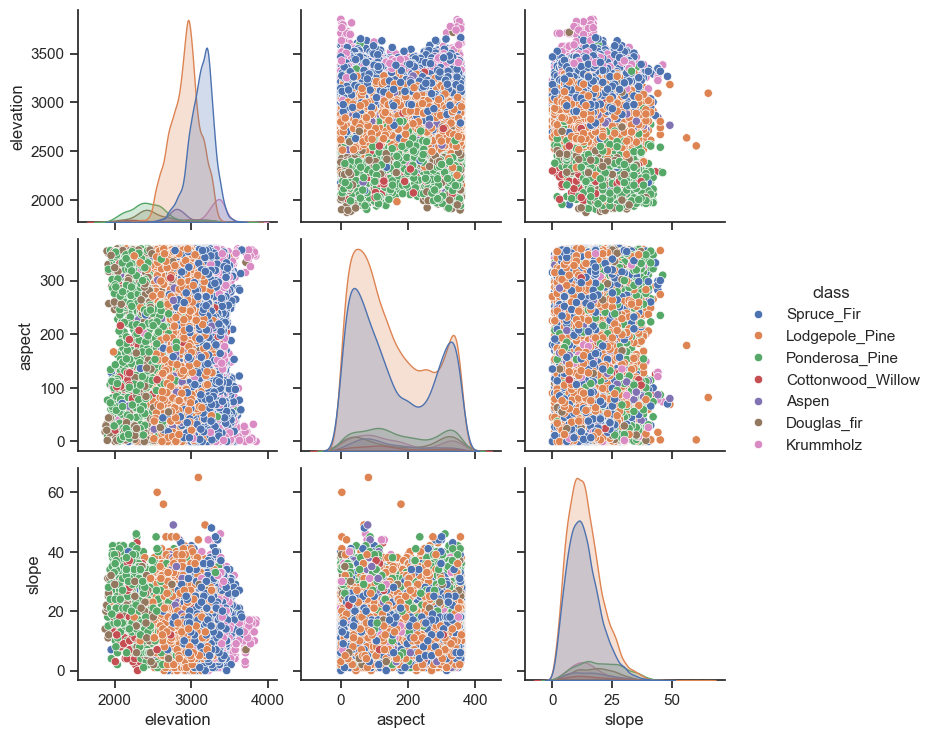

In [10]:
# Setting the visual style of the seaborn plots
sns.set(style="ticks")

# Create the pairplot
sns.pairplot(df.sample(n=n_points), hue="class", vars=["elevation", "aspect", "slope"])

If we carefully look at the *elevation* feature, we see that:
- `Douglus Fir` grows on low elevations
- `Cottonwood Willow` and `Aspen` tend to grow on high elevations
- Some `Pine` categories are seen to grow at lower elevations

---

## The Robustness of Random Forest Classifiers in Handling Unscaled Raw Data

**Decision Trees**, the building blocks of **Random Forests**, make decisions based on conditional splits at each node. These splits are determined by comparing feature values to a threshold and partitioning the data accordingly to minimize a cost function, often related to the impurity of the nodes (e.g., Gini impurity or entropy in classification problems).

Crucially, the decision at each split is based on relative comparisons between values of a single feature at a time, rather than the absolute value itself. This characteristic inherently makes individual Decision Trees less sensitive to the scale of the data; whether a feature ranges between 0 and 1 or 0 and 1000 doesn't change the relative ordering of data points according to that feature. Thus, the effectiveness of the splits, in terms of reducing impurity, remains unaffected by the scale of the features.

**Random Forests enhance the robustness of Decision Trees by creating an ensemble**. Each tree in the forest is trained on a random subset of the data (bootstrapped samples), and at each split, a random subset of features is considered. This strategy introduces two key elements of robustness:
- By sampling different subsets of the data for training each tree, Random Forests ensure that the ensemble captures a wide range of data distributions and patterns. This diversity helps in generalizing well across the dataset, making the model less sensitive to outliers or unusual data scales that might be present in only a portion of the data
- Considering a random subset of features at each split not only increases the diversity among the trees but also mitigates the influence of any single feature's scale on the overall model. By aggregating predictions across many trees, each trained with attention to different features, the ensemble dilutes the impact of scale differences among features. Consequently, features with larger numerical ranges do not necessarily dominate the model's decision-making process.

---

### Task 1 : Random Forests
In this task we will implement the `RandomForestClassifier`to solve the multiclass classification task over the Covertype Dataset. The objective of the task is to observe the performance of the Bagging method using trees of varying depths. It is first requested to go through the documentation of the `RandomForestClassifier` [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).
- In order to assess the performance of the `RandomForestClassifier` across tress with varying depths, we will write a function `evaluate_RF`.
- The arguments of this function are given and are `X`, `y`, a list called `max_depths` and a variable called `scoring` along with an integer parameter `n_estimators`.

In [41]:
## Helper Function for Live Model Plotting (you may directly skip to the cell below)
## [for reference only. useful for analysis.] 

from IPython import display
def plot_live(X, y, evaluator, param_name, param_range, scale='log', ylim=(0,1), ylabel='score', marker = '.'):
    """ Renders a plot that updates with every evaluation from evaluator.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    evaluator -- a function with signature (X, y, param_value) that returns a dictionary of scores.
                 Examples: {"train": 0.9, "test": 0.95} or {"model_1": 0.9, "model_2": 0.7}
    param_name -- the parameter that is being varied on the X axis. Can be a hyperparameter, sample size,...
    param_range -- list of all possible values on the x-axis
    scale -- defines which scale to plot the x-axis on, either 'log' (logarithmic) or 'linear'
    ylim -- tuple with the lowest and highest y-value to plot (e.g. (0, 10))
    ylabel -- the y-axis title
    """
    # Plot interactively
    plt.ion()
    plt.ylabel(ylabel)
    plt.xlabel(param_name)
    
    # Make the scale look nice
    plt.xscale(scale)
    plt.xlim(param_range[0],param_range[-1])
    plt.ylim(ylim)
        
    # Start from empty plot, then fill it
    series = {}
    lines = {}
    xvals = []
    for i in param_range:
        scores = evaluator(X, y, i) 
        if i == param_range[0]: # initialize series
            for k in scores.keys():
                lines[k], = plt.plot(xvals, [], marker = marker, label = k)
                series[k] = []
        xvals.append(i)
        for k in scores.keys(): # append new data
            series[k].append(scores[k])
            lines[k].set_data(xvals, series[k])
        # refresh plot
        plt.legend(loc='best')
        plt.margins(0.1)
        display.display(plt.gcf())
        display.clear_output(wait=True)

In [42]:
def plot_validation(X, y, evaluator):
    Xs, _, ys, _ = train_test_split(X, y, stratify=y, train_size=0.5, random_state=RANDOM_SEED)

    plot_live(
        Xs,
        ys,
        evaluator,
        param_name='n_estimators',
        param_range=range(1, 32, 5),
        scale='linear'
    )

In [43]:
RANDOM_SEED = 42

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import balanced_accuracy_score

def evaluate_RF(X, y, n_estimators, max_depths, scoring):
    res = {}

    for md in max_depths:
        forest = RandomForestClassifier(n_estimators, max_depth=md, random_state=RANDOM_SEED)
        rf = cross_val_score(forest, X, y, cv=3, scoring=scoring)
        res['rf_' + str(md)] = sum(rf)/len(rf)

    return res

The provided Python function `plot_validation` is designed to visualize the performance of a machine learning model — specifically, a Random Forest, given the context — as a function of the number of estimators (`n_estimators`, i.e., trees) in the ensemble.

In [48]:
def evaluate_RF_accuracy(X, y, n_estimators):
    return evaluate_RF(X, y, n_estimators, max_depths=[2, 8, 16, 24, 32, 64], scoring="accuracy")

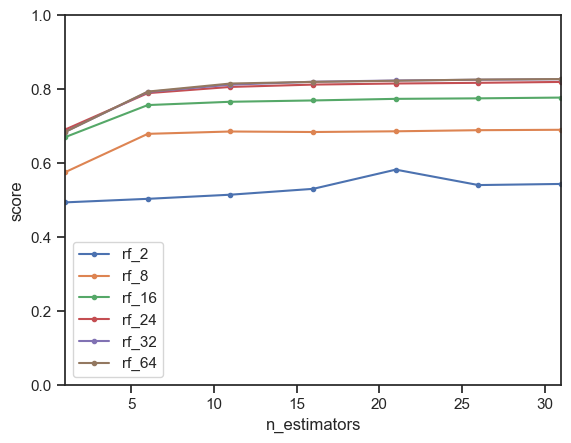

In [49]:
plot_validation(X, y, evaluate_RF_accuracy)

### Task 2: Analyze the Plot

The above plot displays the relationship between the number of trees `n_estimators` within the ensmbled forest with the obtained accurcay across for Random Forest Classifiers with varying depths. Write your analysis below:

> **Solution**: Overall, the more trees, the better the score. The depth of the tree has a much larger effect though. Trees smaller than 32 do not perform well in the ensemble. This is to be expected, since Random Forests is a variance-reduction technique. It will only work if the trees are allowed to overfit. If they underfit, building a random forest ensemble of them won't help. However, trees deeper than 32 do not further improve the score, likely because the trees don't grow much deeper on this dataset.

### Task 3: Evaluating Other Measures
- Based on the above analysis, select the optimal `max_depth` value.
- Write a function `evaluate_RF_balanced` that takes the data `X`, `y` and `n_estimators` as arguments.
- Within the function, call the `evaluate_RF` function with the arguments `X`, `y`, `n_estimators`, `max_depth = ['optimal max_depth']`, `scoring = 'balanced_accuracy'`.
- The function `evaluate_RF_balanced` should return the output of the `evaluate_RF` function.

In [17]:
## Model solution
def evaluate_RF_balanced(X, y, n_estimators):
    return evaluate_RF(X, y, n_estimators, max_depths=[32], scoring='balanced_accuracy')

The [balanced accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) in binary and multiclass classification problems deals with imbalanced datasets. It is defined as the average of recall obtained on each class.

The best value is 1 and the worst value is 0. We plot the `balanced_accuracy` scores for the selected optimal depth of the estimaor trees across varying number of `n_estimators` using the previously defined `plot_1` function.

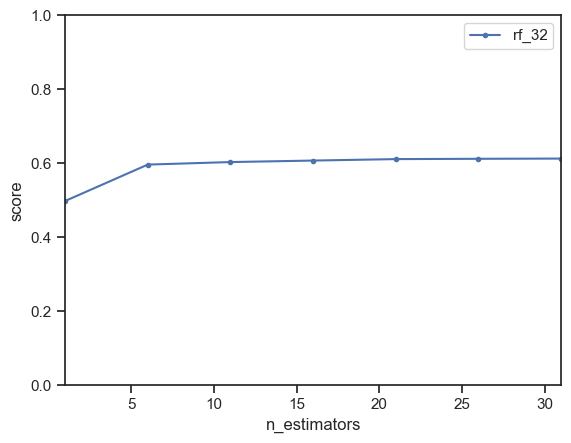

In [18]:
plot_validation(X, y, evaluate_RF_balanced)

## Hyperparameter optimization (HPO)

Hyperparameter optimization (HPO) is essential for tuning the regularization strength. The goal of HPO is to identify the optimal value that balances model complexity with the ability to generalize, thereby minimizing overfitting while maximizing performance on unseen data. Techniques such as grid search, random search, and Bayesian optimization are commonly used for systematically exploring values to find this balance.

The relationship between regularization and HPO is crucial for developing robust models. Models are fine-tuned to achieve the best possible generalization, illustrating the strategic significance of coupling regularization techniques with effective hyperparameter optimization. This process ensures that the regularization not only prevents overfitting but also aligns the model’s complexity with its predictive performance, leading to more accurate and generalizable machine learning outcomes.

### Task 4 : Hyperparameter Optimisation (HPO) using GridSearchCV

In this task we will perform a GridSearch for finding the optimal values of `n_estimators` and the optimal splitting `criterion` namely *gini index* and *entropy*. We shall begin by creating a dictionary object that represents the hyperparameter search space for the hyperparameters corresponding to the `RandomForestClassifier`. It is requested that you go through the documentation of [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) thoroughly. The end goal is to create a `DataFrame` that consists the results of the experiments across different hyperparameter values.

**Instructions**
1. **Initialize the `grid_searches` List:**
   - Your primary objective is to create a list named `grid_searches`. This list will store the results and configurations of the grid search process for each machine learning model you are optimizing. 

2. **Utilize `GridSearchCV` for Hyperparameter Optimization:**
   - For each model in your predefined `models` list, apply the `GridSearchCV` function to automate the search for the best hyperparameters. This function is designed to systematically explore a range of hyperparameter values, evaluating each combination's performance through cross-validation.

3. **Configure `GridSearchCV` Parameters:**
   - When calling `GridSearchCV`, ensure to pass the following parameters:
     - **estimator:** Each model from your `models` list.
     - **param_grid:** The corresponding hyperparameter grid for each model, stored in your `grids` list. This grid specifies the hyperparameters and their respective ranges of values to be tested.
     - **n_jobs=-1:** This argument instructs the process to use all available CPU cores for parallel computation, speeding up the grid search.
     - **cv=3:** Sets up 3-fold cross-validation. In this setup, the data is divided into three parts, where each part is used as a test set while the model is trained on the remaining two parts. This cycle is repeated three times, with each part serving as the test set once. This approach helps in assessing the model's performance more reliably by averaging the results across three different train-test splits.
     - **return_train_score=True:** By setting this parameter to True, the training scores alongside the validation scores are returned, allowing for a comprehensive evaluation of the model's performance over both the training and validation phases.

4. **Execute the Grid Search with Cross-Validation:**
   - The list comprehension iterates over pairs of models and their corresponding hyperparameter grids, executing the `fit` method on `GridSearchCV` objects with the dataset `(X, y)`. This fitting process conducts the grid search combined with 3-fold cross-validation for each model, optimizing hyperparameters while assessing performance across multiple data splits.

5. **Store the Results in `grid_searches`:**
   - The outcomes of the grid search and cross-validation for each model are stored in the `grid_searches` list. This collection will contain comprehensive details on the performance metrics, best scores, best parameters, and fitted models, providing a rich resource for subsequent analysis and model selection.

6. **Get the sorted keys (use the `sorted()` function)**
    -  of the `GridSearchCV` object `grid_searches`. Make use of the `.cv_results_.keys()` method (can be found in the documentation of GridSearchCV) to obtain all the keys.

7. **Create a variable `cv_results`** which stires the Grid Search results using the `.cv_results_` method from `GridSearchCV`

8. **Having done this, create a DataFrame `results_df`,** where the input data is a dictionary with keys obtained using the `.cv_results.keys()` method and the values for these key are extracted from the variable `cv_results`. 
(**Hint** : `df = pd.DataFrame({'mean_fit_time': cv_results['mean_fit_time']})...` )

9. **Display the `results_df` dataframe and present your analysis.**

In [50]:
from sklearn.model_selection import GridSearchCV

param_rf = {
    'n_estimators': np.linspace(10, 200, num=20, dtype=int),  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
}

rf = RandomForestClassifier()
grid_searches = GridSearchCV(rf, param_rf, scoring = 'accuracy', cv=3, return_train_score=True, n_jobs = -1).fit(X,y)

sorted(grid_searches.cv_results_.keys())

cv_results = grid_searches.cv_results_

results_df = pd.DataFrame({
    'mean_fit_time': cv_results['mean_fit_time'],
    'mean_score_time': cv_results['mean_score_time'],
    'mean_test_score': cv_results['mean_test_score'],
    'mean_train_score': cv_results['mean_train_score'],
    'param_criterion': cv_results['param_criterion'],
    'param_n_estimators': cv_results['param_n_estimators'],
    'std_test_score': cv_results['std_test_score'],
    'std_train_score': cv_results['std_train_score'],
    'rank_test_score': cv_results['rank_test_score']
})

# Apply the highlighting
results_df = results_df.sort_values(by = 'rank_test_score')

results_df['param_n_estimators'] = pd.to_numeric(results_df['param_n_estimators'])

/home/renatocf/.cache/pypoetry/virtualenvs/data-mining-KZvXpYHU-py3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [51]:
##Helper  Functon : to highlight text in a DataFrame##

def highlight_best_worst(s):
    """
    Highlight the max and min values in the DataFrame or Series.
    Assume s is a column named 'mean_test_score'.
    """
    is_max = s == s.max()
    is_min = s == s.min()
    return ['background-color: limegreen' if v else 'background-color: salmon' if is_min.iloc[i] else '' for i, v in enumerate(is_max)]


results_df_highlight = results_df.style.apply(highlight_best_worst, subset=['mean_test_score'])

In [52]:
results_df_highlight

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_n_estimators,std_test_score,std_train_score,rank_test_score
38,46.832656,1.687908,0.864847,0.989112,entropy,190,0.001064,0.000672,1
31,37.169902,2.154904,0.864656,0.989107,entropy,120,0.000636,0.000668,2
35,49.182981,2.533273,0.864602,0.989107,entropy,160,0.000359,0.000668,3
32,38.611200,2.293373,0.864511,0.989107,entropy,130,0.000513,0.000679,4
36,51.220632,2.334055,0.864394,0.989107,entropy,170,0.001425,0.000668,5
37,48.808962,1.814997,0.864176,0.989112,entropy,180,0.000633,0.000672,6
29,30.402965,1.715842,0.864122,0.989098,entropy,100,0.001311,0.000670,7
39,41.602072,1.463841,0.864113,0.989112,entropy,200,0.000704,0.000672,8
33,43.060482,2.360204,0.863995,0.989112,entropy,140,0.000439,0.000672,9
27,24.277637,1.593806,0.863569,0.989084,entropy,80,0.001376,0.000657,10


### Task 5: Analyze the Plots

Based on your analysis, select the select the optimal value of `max_depth` (store the value from Task 3), `n_estimators` and `criterion` 

<Axes: xlabel='param_n_estimators', ylabel='mean_test_score'>

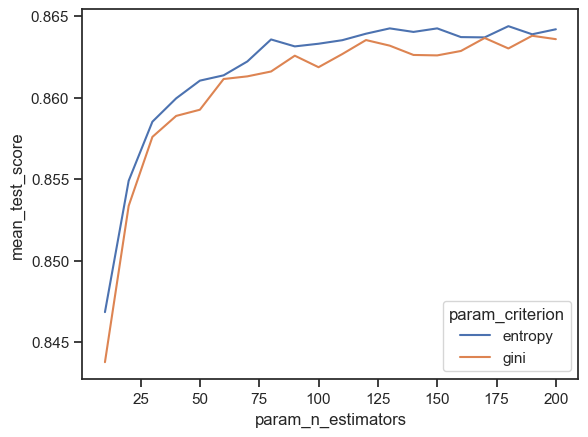

In [22]:
#run the code
sns.lineplot(data=results_df, x="param_n_estimators", y="mean_test_score", hue = 'param_criterion')

In [23]:
max_depth = 32
n_estimators = 50
criterion = 'entropy'

## Lab 4 : Ensemble Learning

### Task 6 : Feature Importance

Having selected the optimal values of the hyperparameters `max_depth`, `n_estimators` and `criterion`, we will now use a `RandomForestClassifier` (set with these hyperparameters) to learn the relationship between `X` and `y`. Moreover, we will use this ensemble learning method for understanding feature importances in our Covertype Data.

**Instructions**
- Call the `RandomForestClassifier` and pass the optimal values of `max_depth`, `n_estimators` and `criterion` to the constructer call. Store this call in a variable called `forest`.
- Call the `.fit` on `forest` and fit the feature and target data (`X,y`).
- Call the `plot_feature_importance` helper function by passing the list `features` (defined at the begining) and `forest` as arguments for visualizing the feature importance.
- Present your analysis based on the obtained plot.

In [24]:
##Helper Function : For plotting the feature importances##

def plot_feature_importances(features, model):
    n_features = len(features)
    plt.figure(figsize=(5,10))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(range(n_features), features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

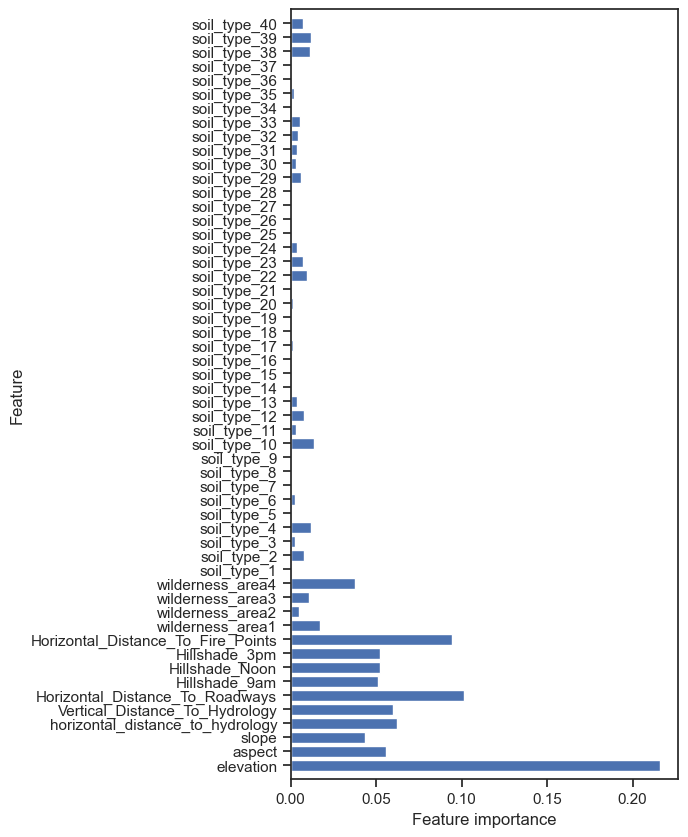

In [53]:
forest = RandomForestClassifier(random_state=0, n_estimators=50, max_depth=32, n_jobs=-1, criterion='entropy')
forest.fit(X,y)
plt.rcParams.update({'font.size':8})
plot_feature_importances(features, forest)

### Task 7 : Feature Selection


**instructions**
- Based on the above plot select the first 10 features from `X`. call the `evaluate_RF` function, pass the data with 10 features from `X`, `y`. The evaluation metric must be `balanced_accuracy`. Present the `balanced_aacuracy` scores and the time taken to `fit` the classifier.

- Compare the performance with a fit on full data (with all the features) along with the time taken to fit the classifier.

- `time` can be calculated using the `time()` method present in the `time` library. Kindly refer to the documentation of `time` [here](https://docs.python.org/3/library/time.html).

In [54]:
##Solution : Write your code here
import time

start = time.time()
start = time.time()
score = evaluate_RF(X, y, 25, max_depths=[32], scoring='balanced_accuracy')
print("Normal RF: {:.2f} balanced ACC, {:.2f} seconds".format(score['rf_32'], (time.time()-start)))
start = time.time()
score = evaluate_RF(X.iloc[:, :10], y, 25, max_depths=[32], scoring='balanced_accuracy')
print("Feature Selection RF: {:.2f} balanced ACC, {:.2f} seconds".format(score['rf_32'], (time.time()-start)))

Normal RF: 0.65 balanced ACC, 9.03 seconds
Feature Selection RF: 0.63 balanced ACC, 10.66 seconds


### Task 8 : Analyze the Performance on varying Features

Given the results from the previous code execution, please provide an analysis of how Random Forest models manage varying feature sets and discuss their resilience and adaptability in this context.

#### Solution

The first 10 features are the most significant according to the random forest. If we select only those, we get a very similar (but slightly worse) result. Random forests is already very robust against irrelevant features. Removing irrelevant features
in this way doesn't help much. The runtime is also about the same.

### Task 9 : Consfusion Matrix
We would like to generate the confusion matrix of the tuned random forest to better understand which classes are still often confused?

**Instructions**

- Use `train_test_split` to create standard stratified holdout
- Call the `RandomForestClassifier` and set the optimal hyperparameters
- Fit the model on `X_train` and `y_train`
- Make predictions on `X_test` and store them in a variable `y_test_pred`
- Use the [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) evaluation method from the sklearn to produce the required confusion matrix. 
- Present your final analysis in the end

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

##Write your solution here:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=1)
tuned_forest = RandomForestClassifier(random_state=0, n_estimators=25, max_depth=32, n_jobs=-1).fit(X_train, y_train)
confusion_matrix(y_test, tuned_forest.predict(X_test))

array([[  281,     1,     9,     8,   237,    25,    92],
       [    4,    92,     7,     5,   120,    40,    67],
       [    2,     3,   613,     7,   168,   124,    75],
       [    4,     2,    13,   812,   118,    17,   161],
       [   36,    22,    56,    28, 12061,    59,   659],
       [   10,    15,    70,    12,   165,  1501,    71],
       [   30,    22,    27,    61,  1104,    30,  8453]])

Write your Analaysis Here :